In [32]:
from model import Experiment
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import trange
import umap

# train a classifier to distinguish between RSA and Naive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## 1. Differences in cost

In [28]:
def preference_diff(alpha=1, model="RSA"):
    results = defaultdict(list)
    for _ in trange(10):
        for length in range(0, 10, 1):
            exp = Experiment(alpha, np.array([1, 1, 1])/3, np.array([0, length]), np.array([[1, 1, 0], [1, 0, 1]]), 100, 120, model=model)
            exp.run()
            df = exp.save(rd=True)

            # group by trial and compute mean accuracy
            # only keep trials where mean accuracy is higher than 2/3

            df_ = df.groupby(['trial']).agg({'correct': 'mean'}).reset_index()
            df_ = df_[df_['correct'] > 2/3]

            df = df[df['round'] >= 80]

            # get trials from df_ and constrain the df
            df = df[df['trial'].isin(df_['trial'])]

            perc = df[(df['word'] == 1) & (df['meaning'] == 0)].shape[0] / df[df['meaning'] == 0].shape[0]

            results[length].append(perc)
    return results

In [30]:
# res = preference_diff(10, "RSA")

In [ ]:
res_ = preference_diff(10, "naive")

  0%|          | 0/10 [00:00<?, ?it/s]

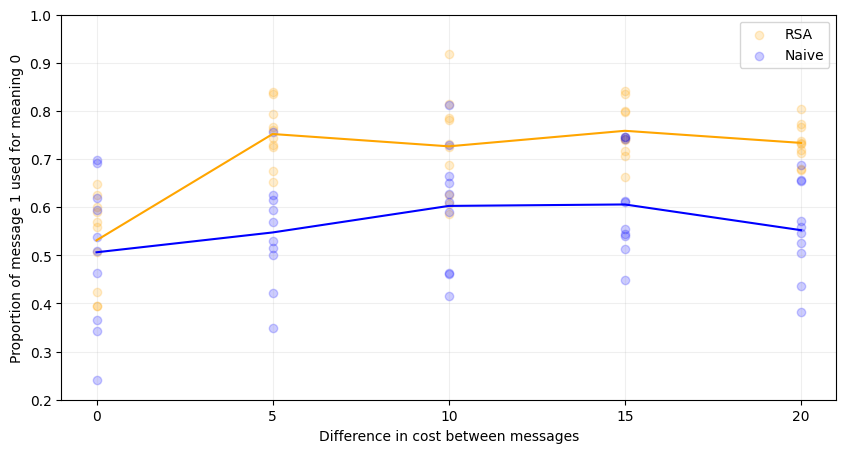

In [ ]:
# plot res and res_ as two subplots on the same figure
plt.figure(figsize=(10, 5))
plt.grid(alpha=0.2)

# Plot each individual run
for k in res.keys():
    plt.scatter([k] * len(res[k]), res[k], color='orange', alpha=0.2)
    plt.scatter([k] * len(res_[k]), res_[k], color='blue', alpha=0.2)

plt.plot(list(res.keys()), [np.mean(res[k]) for k in res.keys()], color='orange')
plt.plot(list(res_.keys()), [np.mean(res_[k]) for k in res_.keys()], color='blue')

plt.xlabel('Difference in cost between messages')
plt.ylabel('Proportion of message 1 used for meaning 0')
plt.xticks(list(res.keys()))
plt.ylim(0.2, 1)
plt.legend(["RSA", "Naive"])
plt.show()

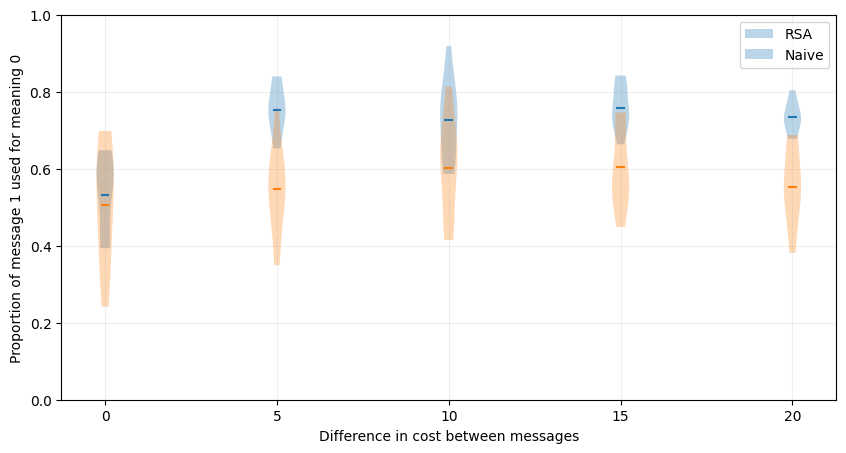

In [ ]:
# get all the values from res and res_ and plot them as a violin plot
plt.figure(figsize=(10, 5))
plt.grid(alpha=0.2)

plt.violinplot([res[k] for k in res.keys()], positions=list(res.keys()), showmeans=True, showextrema=False, widths=0.5)
plt.violinplot([res_[k] for k in res_.keys()], positions=list(res_.keys()), showmeans=True, showextrema=False, widths=0.5)

plt.xlabel('Difference in cost between messages')
plt.ylabel('Proportion of message 1 used for meaning 0')
plt.xticks(list(res.keys()))
plt.ylim(0, 1)
plt.legend(["RSA", "Naive"])

## 2. Model comparison

In [43]:
def simulate_data(n_iter=30, n_rounds=42, model="RSA", sims = 20):
    results = []
    for _ in range(sims):
        exp = Experiment(1, np.array([1, 1, 1])/3, np.array([0, 40]), 
                        np.array([[1, 1, 0], [1, 0, 1]]), n_iter=n_iter, 
                        n_rounds=n_rounds, model=model)
        exp.run()
        df = exp.save(rd=True)
        inf_short = (df.query('word_length == 0 & meaning in [1, 2]').groupby('trial').count()['round'] \
                    / df.query('meaning in [1, 2]').groupby('trial').count()['round']).to_numpy()
        nin_long = (df.query('word_length == 40 & meaning == 0').groupby('trial').count()['round'] \
                    / df.query('meaning == 0').groupby('trial').count()['round']).to_numpy()
        np.nan_to_num(inf_short, copy=False)
        np.nan_to_num(nin_long, copy=False)
        results.append(np.array([inf_short, nin_long]))
    return results

In [44]:
out_naive = simulate_data(sims=500, model="naive")
out_rsa = simulate_data(sims=500, model="RSA")

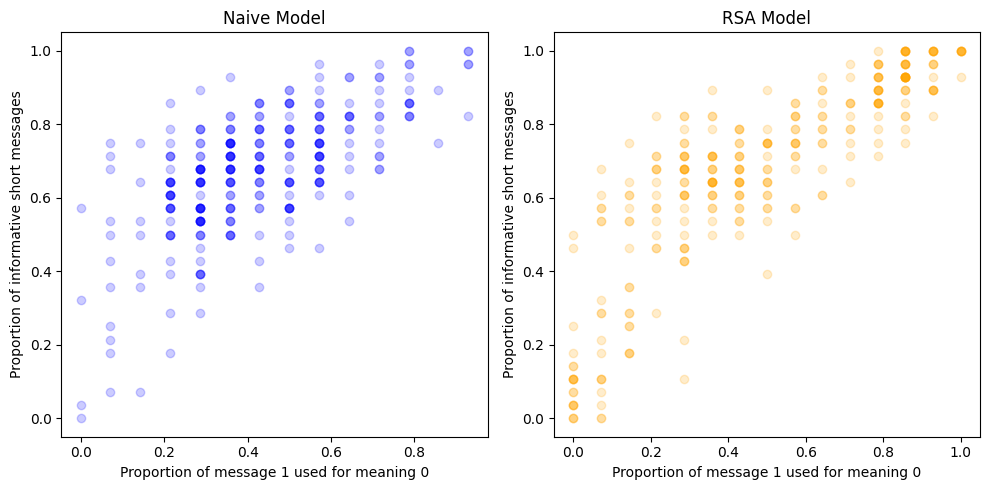

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for _ in range(10):
    axs[0].scatter(out_naive[_][1], out_naive[_][0], color='blue', alpha=0.2)
axs[0].set_xlabel('Proportion of message 1 used for meaning 0')
axs[0].set_ylabel('Proportion of informative short messages')
axs[0].set_title('Naive Model')

for _ in range(10):
    axs[1].scatter(out_rsa[_][1], out_rsa[_][0], color='orange', alpha=0.2)
axs[1].set_xlabel('Proportion of message 1 used for meaning 0')
axs[1].set_ylabel('Proportion of informative short messages')
axs[1].set_title('RSA Model')

plt.tight_layout()
plt.show()

In [46]:
true_dat = simulate_data(sims=1, model="RSA")[0]

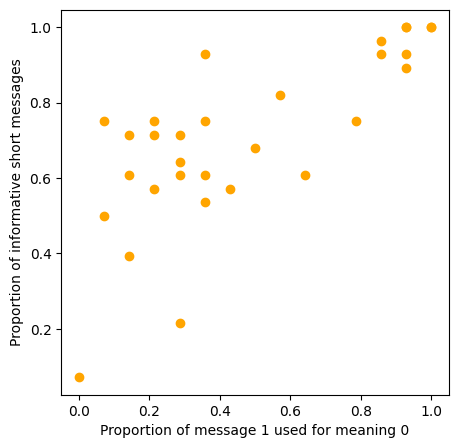

In [47]:
# plot true data
plt.figure(figsize=(5, 5))
plt.scatter(true_dat[1], true_dat[0], color='orange', alpha=1)
plt.xlabel('Proportion of message 1 used for meaning 0')
plt.ylabel('Proportion of informative short messages')
plt.show()

In [48]:
X = np.concatenate([[_.flatten() for _ in out_rsa], [_.flatten() for _ in out_naive]])
y = np.concatenate([np.ones(500), np.zeros(500)])

In [49]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [50]:
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 1000],
    'max_depth': [1, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 1000}
Best Score: 0.9524999999999999


In [51]:
clf = RandomForestClassifier(**best_params)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.91

In [52]:
# predict on true data
clf.predict([true_dat.flatten()])

array([1.])

In [53]:
# predict proba
clf.predict_proba([true_dat.flatten()])

array([[0.145, 0.855]])

In [54]:
acc_rsa = 0
acc_naive = 0

for _ in range(100):
    true_rsa = simulate_data(sims=1, model="RSA")[0]
    true_naive = simulate_data(sims=1, model="naive")[0]

    rsa_pred = clf.predict([true_rsa.flatten()])
    naive_pred = clf.predict([true_naive.flatten()])

    if rsa_pred == 1:
        acc_rsa += 1
    if naive_pred == 0:
        acc_naive += 1

In [ ]:
acc_rsa / 100

0.95

In [ ]:
acc_naive / 100

0.94